In [ ]:
!pip install yfinance prophet statsmodels

In [ ]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [ ]:
ticker = "TITAN.NS"
print(f"Downloading data for {ticker}")
data = yf.download(ticker, start="2019-01-01", end="2023-01-01")


/tmp/ipython-input-1977077557.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2019-01-01", end="2023-01-01")
[*********************100%***********************]  1 of 1 completed


In [ ]:
df = data[['Close']].reset_index()
df.columns = ['ds', 'y']


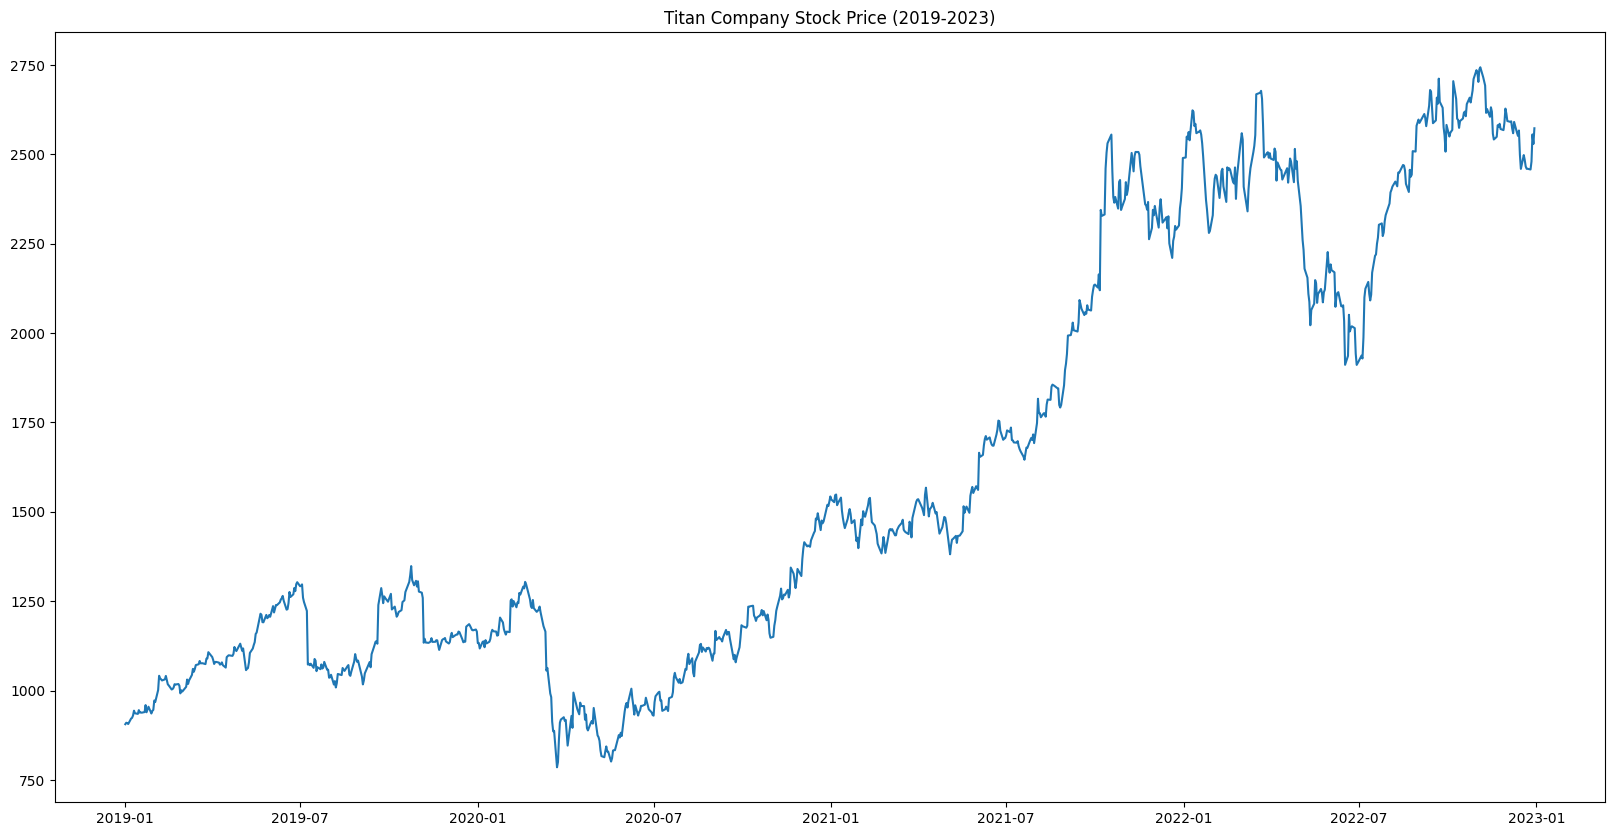

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(df['ds'], df['y'])
plt.title("Titan Company Stock Price (2019-2023)")
plt.show()


## Breaking the data in between to check Prophet vs ARIMA

In [ ]:
start_hole = pd.to_datetime("2021-09-01") #When the data is broken in between
end_hole = pd.to_datetime("2021-12-31") #Till when it is broken to
df_train = df.copy()

df_train.loc[(df_train['ds'] >= start_hole) & (df_train['ds'] <= end_hole), 'y'] = None

print("Data sabotaged. Missing 4 months of data including Diwali 2021.")


Data sabotaged. Missing 4 months of data including Diwali 2021.


#ARIMA

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

df_arima = df_train.set_index('ds').fillna(method='ffill')

# (Order 5,1,0 is a standard starting point for stocks)
model_arima = ARIMA(df_arima['y'], order=(5,1,0))
arima_result = model_arima.fit()


df_arima['arima_pred'] = arima_result.predict(start=0, end=len(df_arima)-1)


/tmp/ipython-input-4047601483.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_arima = df_train.set_index('ds').fillna(method='ffill')
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
from prophet import Prophet

m = Prophet(daily_seasonality=True)
m.add_country_holidays(country_name='IN')

m.fit(df_train)

future = m.make_future_dataframe(periods=0)
forecast = m.predict(future)

/usr/local/lib/python3.12/dist-packages/holidays/countries/india.py:188: Warning: Requested Holidays are available only from 2001 to 2035.
  warnings.warn(warning_msg, Warning)


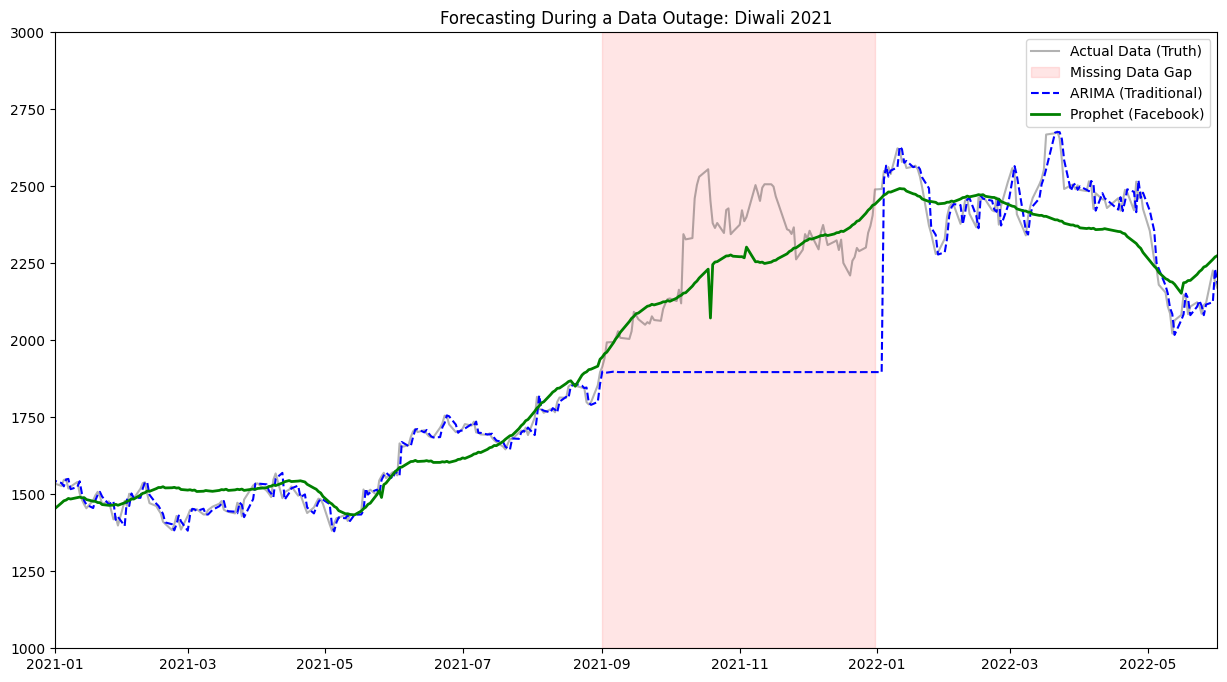

In [ ]:
plt.figure(figsize=(15, 8))

# Actual Values
plt.plot(df['ds'], df['y'], 'k-', label='Actual Data (Truth)', alpha=0.3)

# Highlight the Missing Region
plt.axvspan(start_hole, end_hole, color='red', alpha=0.1, label='Missing Data Gap')

# ARIMA
plt.plot(df_arima.index, df_arima['arima_pred'], 'b--', label='ARIMA (Traditional)')

#  Prophet
plt.plot(forecast['ds'], forecast['yhat'], 'g-', linewidth=2, label='Prophet (Facebook)')

plt.xlim([pd.to_datetime("2021-01-01"), pd.to_datetime("2022-06-01")])
plt.ylim([1000, 3000]) # Adjust based on Titan price range

plt.title("Forecasting During a Data Outage: Diwali 2021")
plt.legend()
plt.show()

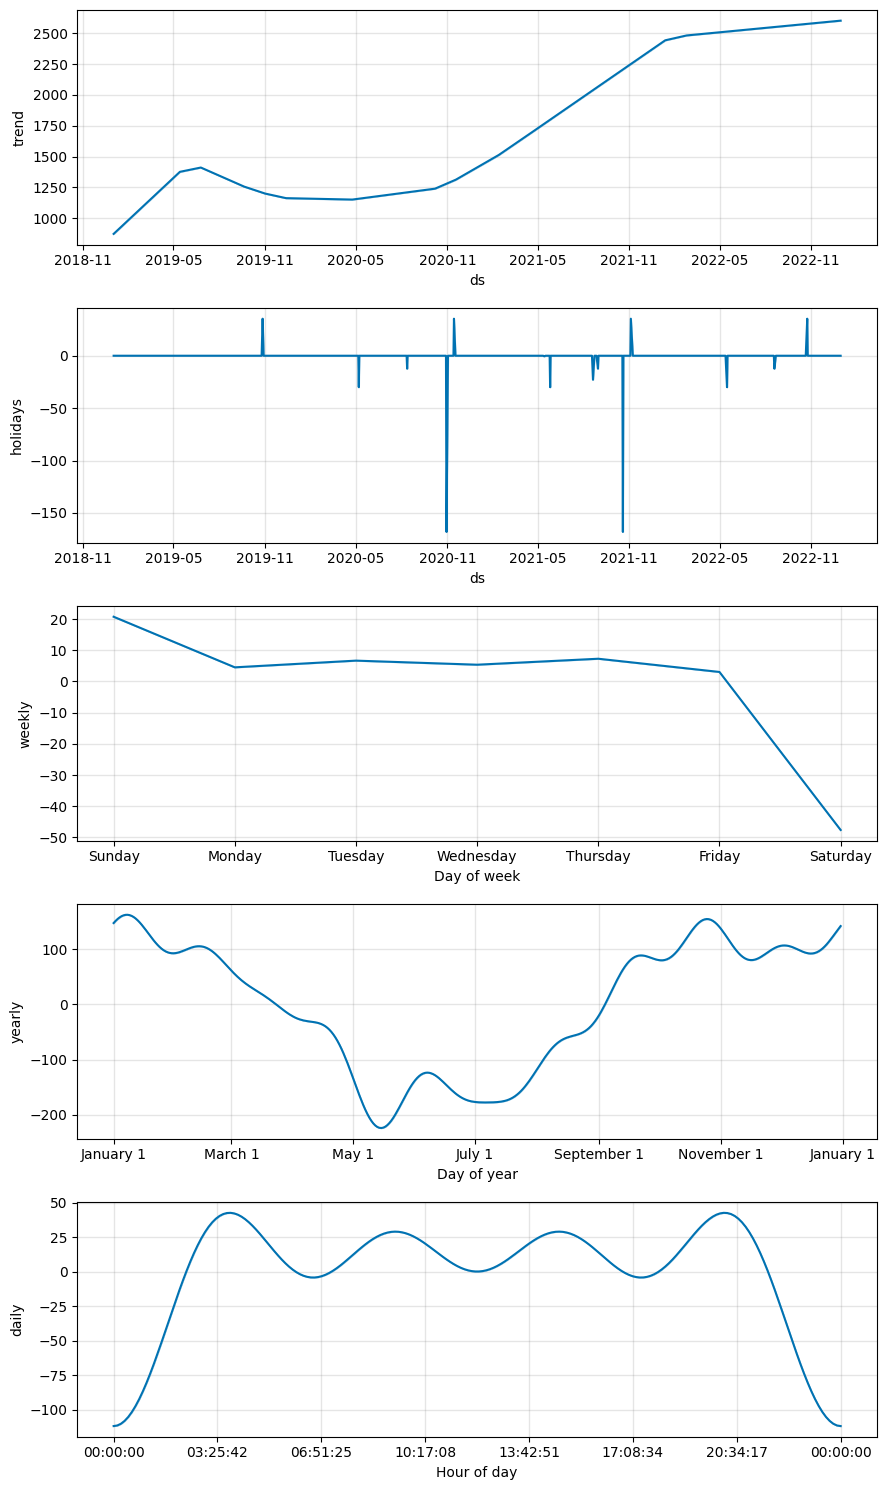

In [ ]:
fig2 = m.plot_components(forecast)

# Adjust layout for readability
plt.show()


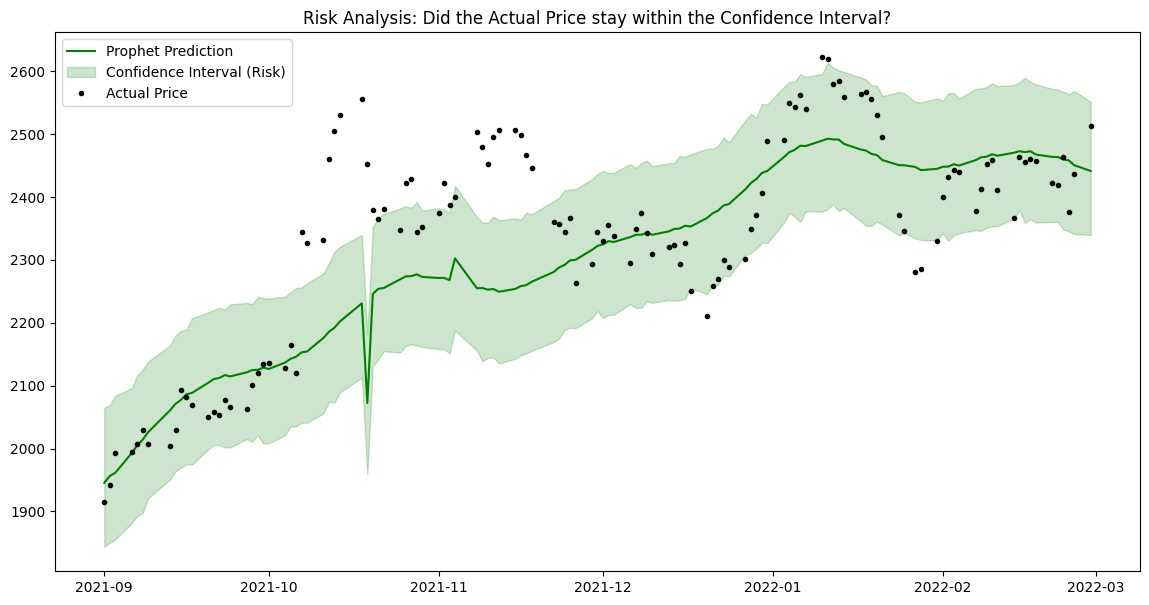

In [ ]:
zoom_start = pd.to_datetime("2021-09-01")
zoom_end = pd.to_datetime("2022-03-01")

# Filter data for zooming
mask = (forecast['ds'] >= zoom_start) & (forecast['ds'] <= zoom_end)
zoomed_forecast = forecast.loc[mask]
zoomed_truth = df.loc[(df['ds'] >= zoom_start) & (df['ds'] <= zoom_end)]

plt.figure(figsize=(14, 7))

# 1. Plot the Prediction line
plt.plot(zoomed_forecast['ds'], zoomed_forecast['yhat'], color='green', label='Prophet Prediction')

# 2. Plot the "Cone of Uncertainty" (The Risk Zone)
plt.fill_between(zoomed_forecast['ds'],
                 zoomed_forecast['yhat_lower'],
                 zoomed_forecast['yhat_upper'],
                 color='green', alpha=0.2, label='Confidence Interval (Risk)')

# 3. Plot the Actual Truth (to see if it stayed inside the risk zone)
plt.plot(zoomed_truth['ds'], zoomed_truth['y'], 'k.', label='Actual Price')

plt.title("Risk Analysis: Did the Actual Price stay within the Confidence Interval?")
plt.legend()
plt.show()
